In [1]:
!pip install scikit-image
!pip install opencv-python-headless
import skimage
import skimage.feature
import skimage.viewer
import matplotlib.pyplot as plt

     |████████████████████████████████| 29.2 MB 22.8 MB/s 
     |████████████████████████████████| 169 kB 81.1 MB/s 
     |████████████████████████████████| 4.4 MB 41.8 MB/s 
     |████████████████████████████████| 1.6 MB 44.1 MB/s 
     |████████████████████████████████| 3.3 MB 60.7 MB/s 
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 38.2 MB 23.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Viewer requires Qt
  """


In [2]:
from PIL import Image
import numpy as np

img  =  Image.open("pics/heatmap.png")
img_np =  np.asarray(img)

In [3]:
img_grey = np.array(img.convert('L'),'f')

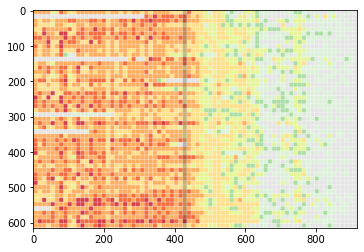

In [4]:
plt.imshow(img_np)

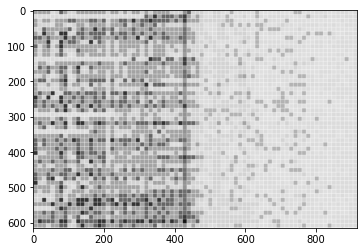

In [5]:
plt.imshow(img_grey, cmap='gray')

In [6]:
import pandas as pd
import csv
import re

with open('DMC_RGB.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]

pattern = re.compile(r".*<td>(.*?)</td>")
data_all = []
for line in rows:
    content = ''.join(line)
    if re.match(r"(.*)<td>(.*?)</td>", content):
        data = re.search(pattern, content)
        data_all.append(data.group(1))

floss = data_all[::7]
name = data_all[1::7]
Red = data_all[2::7]
Green = data_all[3::7]
Blue = data_all[4::7]
RGB_code = data_all[5::7]
row = data_all[6::7]

dmc_rgb = {"floss": floss,\
"name": name, \
"Red": list(map(int,Red)), \
"Green": list(map(int,Green)), \
"Blue": list(map(int,Blue)), \
"RGB_code": RGB_code, \
"row": row}
dmc_rgb = pd.DataFrame(dmc_rgb)

rgb_matrix = dmc_rgb[["Red","Green","Blue"]]

In [7]:
rgb_matrix

,Red,Green,Blue
0,255,226,226
1,255,201,201
2,245,173,173
3,241,135,135
4,227,109,109
...,...,...,...
449,132,132,132
450,108,108,108
451,86,86,86
452,66,66,66


In [8]:
w, h = img.size
num_w = 100
block_size = w // num_w
num_h = h * num_w // w

In [9]:
img = img.resize((num_w*block_size, num_h*block_size))
img_np =  np.asarray(img)
img_grey = np.array(img.convert('L'),'f')

In [10]:
edges = skimage.feature.canny(img_grey, sigma = 0.5,  low_threshold = 100, high_threshold = 200)

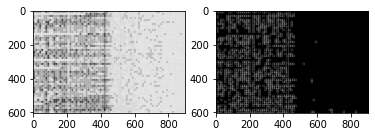

In [11]:
images = [img_grey, edges]
location = [121, 122] 
for loc, edge_image in zip(location, images): 
   plt.subplot(loc) 
   plt.imshow(edge_image, cmap='gray')

In [12]:
def edge_detection(block_pixels, edges):
    edge_pixels = []
    for pixel in block_pixels:
        if edges[pixel[0], pixel[1]] == True:
            edge_pixels.append(pixel)
    if edge_pixels:
        return edge_pixels
    else:
        return False

def edge_or_not(s, edges):
    if True in edges[s[0]: s[2]+1, s[1]:s[3]+1]:
        return True
    else:
        return False

def get_averageRGB(img_array, s, block_size):
  block_img = img_array[s[0]:s[2] + 1, s[1]:s[3] + 1]
  return np.average(block_img.reshape(block_size**2, 3), axis=0).astype(int)

def change_block_2(x, y, block_size, img_array):
    block_pixels = []
    block_sides = [x, y, x + block_size - 1, y + block_size - 1]
    for i in range(block_size):
        for j in range(block_size):
            block_pixels.append([x + i, y + j])
    new_color = get_averageRGB(img_array, block_sides, block_size)
    return block_pixels, new_color

def change_block(x, y, block_size, img_array, edges):
    block_pixels = []
    block_sides = [x, y, x + block_size - 1, y + block_size - 1]
    for i in range(block_size):
        for j in range(block_size):
            block_pixels.append([x + i, y + j])

    if edge_or_not(block_sides, edges):   # ONLY CONSIDER PICTURES WITHOUT DISTINCT CONTOURS
        color_dict = {}
        colors = {}
        for pixel in block_pixels:
            if not str(img_array[pixel[0], pixel[1]]) in color_dict.keys():
                color_dict[str(img_array[pixel[0], pixel[1]])] = 1
                colors[str(img_array[pixel[0], pixel[1]])] = img_array[pixel[0], pixel[1]]
            else:
                color_dict[str(img_array[pixel[0], pixel[1]])] += 1
        max_color_num = max(color_dict.values())
        max_color = [k for k,v in color_dict.items() if v == max_color_num]
        max_color_list = np.array([v for k,v in colors.items() if k in max_color])
        new_color = np.average(np.array(max_color_list), axis = 0).astype(int)
    else:
        new_color = get_averageRGB(img_array, block_sides, block_size)
    return block_pixels, new_color


In [13]:
width, height = num_w*block_size, num_h*block_size
img_new2 = img_np.copy()
img_np_resized2 = np.zeros((num_h, num_w, 3))
for x in range(0,height,block_size):
    for y in range(0,width,block_size):
        block_pixels = change_block_2(x, y, block_size, img_np)[0]
        block_color = change_block_2(x, y, block_size, img_np)[1]
        img_np_resized2[int(x/block_size)][int(y/block_size)] = block_color
        for pixel in block_pixels:
            img_new2[pixel[0], pixel[1]] = block_color

img_new = img_np.copy()
img_np_resized = np.zeros((num_h, num_w, 3))
for x in range(0,height,block_size):
    for y in range(0,width,block_size):
        block_pixels = change_block(x, y, block_size, img_np, edges)[0]
        block_color = change_block(x, y, block_size, img_np, edges)[1]
        img_np_resized[int(x/block_size)][int(y/block_size)] = block_color
        for pixel in block_pixels:
            img_new[pixel[0], pixel[1]] = block_color

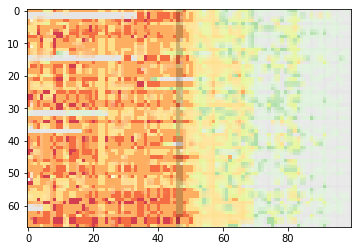

In [14]:
plt.imshow(img_np_resized.astype('uint8'))

In [15]:
img_colormap = img_np_resized.astype('uint8')

In [17]:
import cv2
img_colormap_grey = cv2.cvtColor(img_colormap,cv2.COLOR_BGR2GRAY)

In [18]:
def rgb2grey(pixel):
    (b, g, r) = pixel
    b = int(b)
    g = int(g)
    r = int(r)
    gray = r*0.299 + g*0.587 + b*0.114
    return(gray)

img_colormap_grey2 = np.zeros([num_h, num_w], np.uint8)
for i in range(num_h):
    for j in range(num_w):
        pixel = img_colormap[i, j]
        gray = rgb2grey(pixel)
        img_colormap_grey2[i, j] = np.uint8(gray)

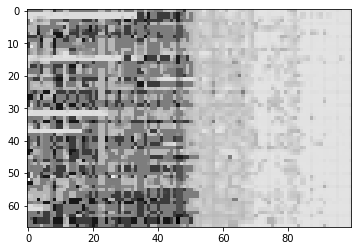

In [19]:
plt.imshow(img_colormap_grey2, cmap='gray')

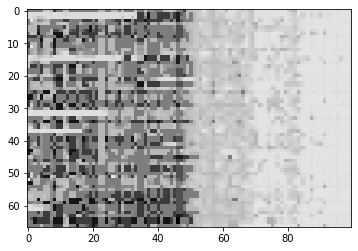

In [20]:
plt.imshow(img_colormap_grey, cmap='gray')

### Given palette (Random)

In [21]:
random_palette = dmc_rgb.sample(n = 30)

In [22]:
random_palette

,floss,name,Red,Green,Blue,RGB_code,row
112,794,Cornflower Blue Light,143,156,193,8F9CC1,row 05-20
101,553,Violet,163,99,139,A3638B,row 05-09
208,561,Celadon Green VD,44,106,69,2C6A45,row 09-21
237,3346,Hunter Green,64,106,58,406A3A,row 10-23
350,921,Copper,198,98,24,C66218,row 15-08
298,746,Off White,252,252,238,FCFCEE,row 13-09
9,350,Coral Medium,224,72,72,E04848,row 01-10
182,926,Gray Green Med,152,174,174,98AEAE,row 08-22
305,783,Topaz Medium,206,145,36,CE9124,row 13-16
376,3830,Terra Cotta,185,85,68,BC5544,row 16-12


In [23]:
random_palette_rgb = random_palette[["Red","Green","Blue"]]

In [28]:
random_palette_lu = []
for color in np.array(random_palette_rgb):
    gray = rgb2grey(color)
    random_palette_lu.append(np.uint8(gray))

In [30]:
random_palette_lu = np.array(random_palette_lu)
random_palette_lu

array([165, 118,  87,  86,  87, 247,  89, 171, 119,  91, 235,  53, 224,
       224, 204, 113, 108, 178,  51, 139,  80, 204, 137, 113,  82, 153,
       137, 190, 207, 143], dtype=uint8)

In [31]:
img_colormap_grey2

array([[159, 159, 159, ..., 233, 233, 229],
       [229, 229, 229, ..., 233, 234, 231],
       [229, 229, 222, ..., 233, 234, 231],
       ...,
       [159, 132,  84, ..., 233, 234, 231],
       [159, 158,  84, ..., 233, 234, 231],
       [159, 158, 159, ..., 234, 234, 232]], dtype=uint8)

In [78]:
img_colormap_rgb_converted = img_colormap.copy()
img_colormap_lu_converted = img_colormap.copy()
for row in range(num_h):
    for col in range(num_w):
        lu = img_colormap_grey2[row][col]
        c = img_colormap[row][col]
        all_rgb_dist = list(map(lambda x: np.linalg.norm(x - c), np.array(random_palette_rgb)))
        which_min = all_rgb_dist.index(min(all_rgb_dist))
        all_lu_dist = abs(lu - random_palette_lu).tolist()
        which_min_lu = all_lu_dist.index(min(all_lu_dist))
        change_rgb = np.array(random_palette_rgb.iloc[which_min])
        change_lu = np.array(random_palette_rgb.iloc[which_min_lu])
        img_colormap_rgb_converted[row][col] = change_rgb
        img_colormap_lu_converted[row][col] = change_lu

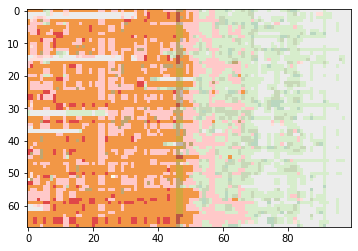

In [79]:
plt.imshow(img_colormap_rgb_converted)

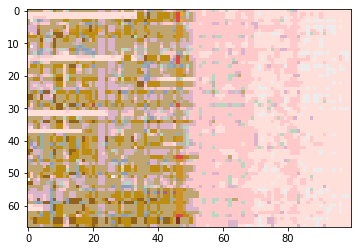

In [80]:
plt.imshow(img_colormap_lu_converted)

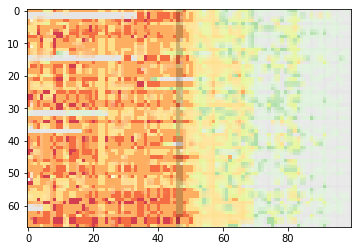

In [81]:
plt.imshow(img_colormap)

### Given palette(same colour system)

In [53]:
chosen_palette = dmc_rgb.head(30)

In [41]:
chosen_palette_rgb = chosen_palette[["Red","Green","Blue"]]

In [43]:
chosen_palette_lu = []
for color in np.array(chosen_palette_rgb):
    gray = rgb2grey(color)
    chosen_palette_lu.append(np.uint8(gray))

chosen_palette_lu = np.array(chosen_palette_lu)

In [77]:
img_colormap_rgb_converted = img_colormap.copy()
img_colormap_lu_converted = img_colormap.copy()
for row in range(num_h):
    for col in range(num_w):
        lu = img_colormap_grey2[row][col]
        c = img_colormap[row][col]
        all_rgb_dist = list(map(lambda x: np.linalg.norm(x - c), np.array(chosen_palette_rgb)))
        which_min = all_rgb_dist.index(min(all_rgb_dist))
        all_lu_dist = abs(lu - chosen_palette_lu).tolist()
        which_min_lu = all_lu_dist.index(min(all_lu_dist))
        change_rgb = np.array(chosen_palette_rgb.iloc[which_min])
        change_lu = np.array(chosen_palette_rgb.iloc[which_min_lu])
        # print(lu,min(all_lu_dist),which_min_lu,chosen_palette_lu[which_min_lu],change_lu)
        img_colormap_rgb_converted[row][col] = change_rgb
        img_colormap_lu_converted[row][col] = change_lu

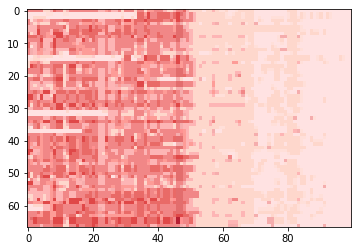

In [55]:
plt.imshow(img_colormap_rgb_converted)

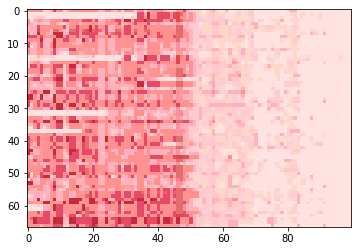

In [76]:
plt.imshow(img_colormap_lu_converted)

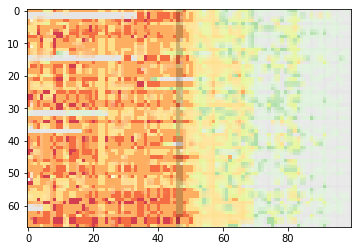

In [57]:
plt.imshow(img_colormap)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=768076c7-65ce-42d5-b86d-074f9f75d785' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>